In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
34450,NaN,NaN,International,2020-03-01,705.0,0.0,6.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34451,NaN,NaN,International,2020-03-02,705.0,0.0,6.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34452,NaN,NaN,International,2020-03-10,696.0,-9.0,7.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


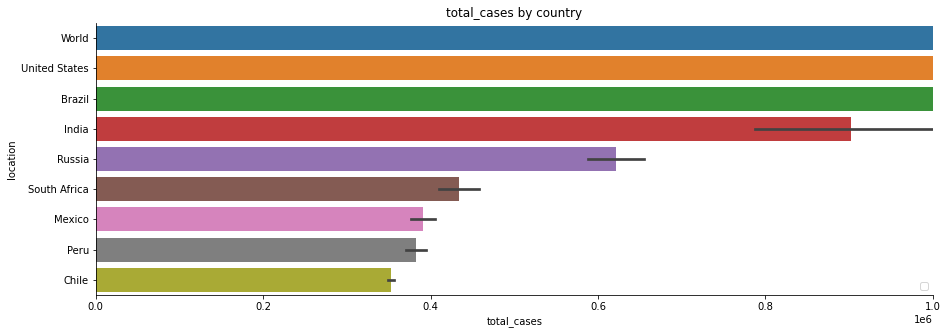

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


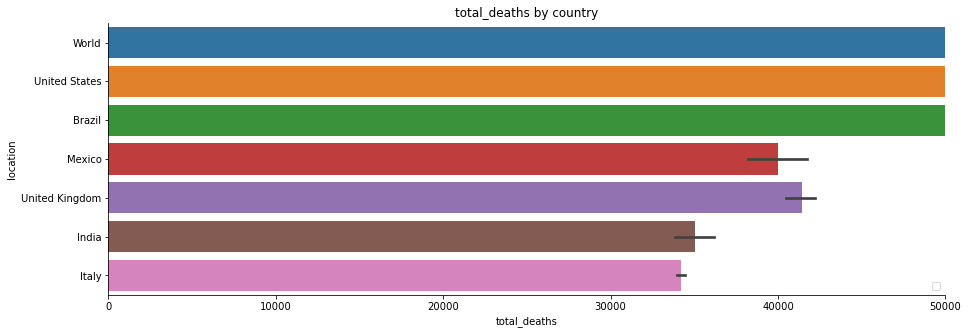

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


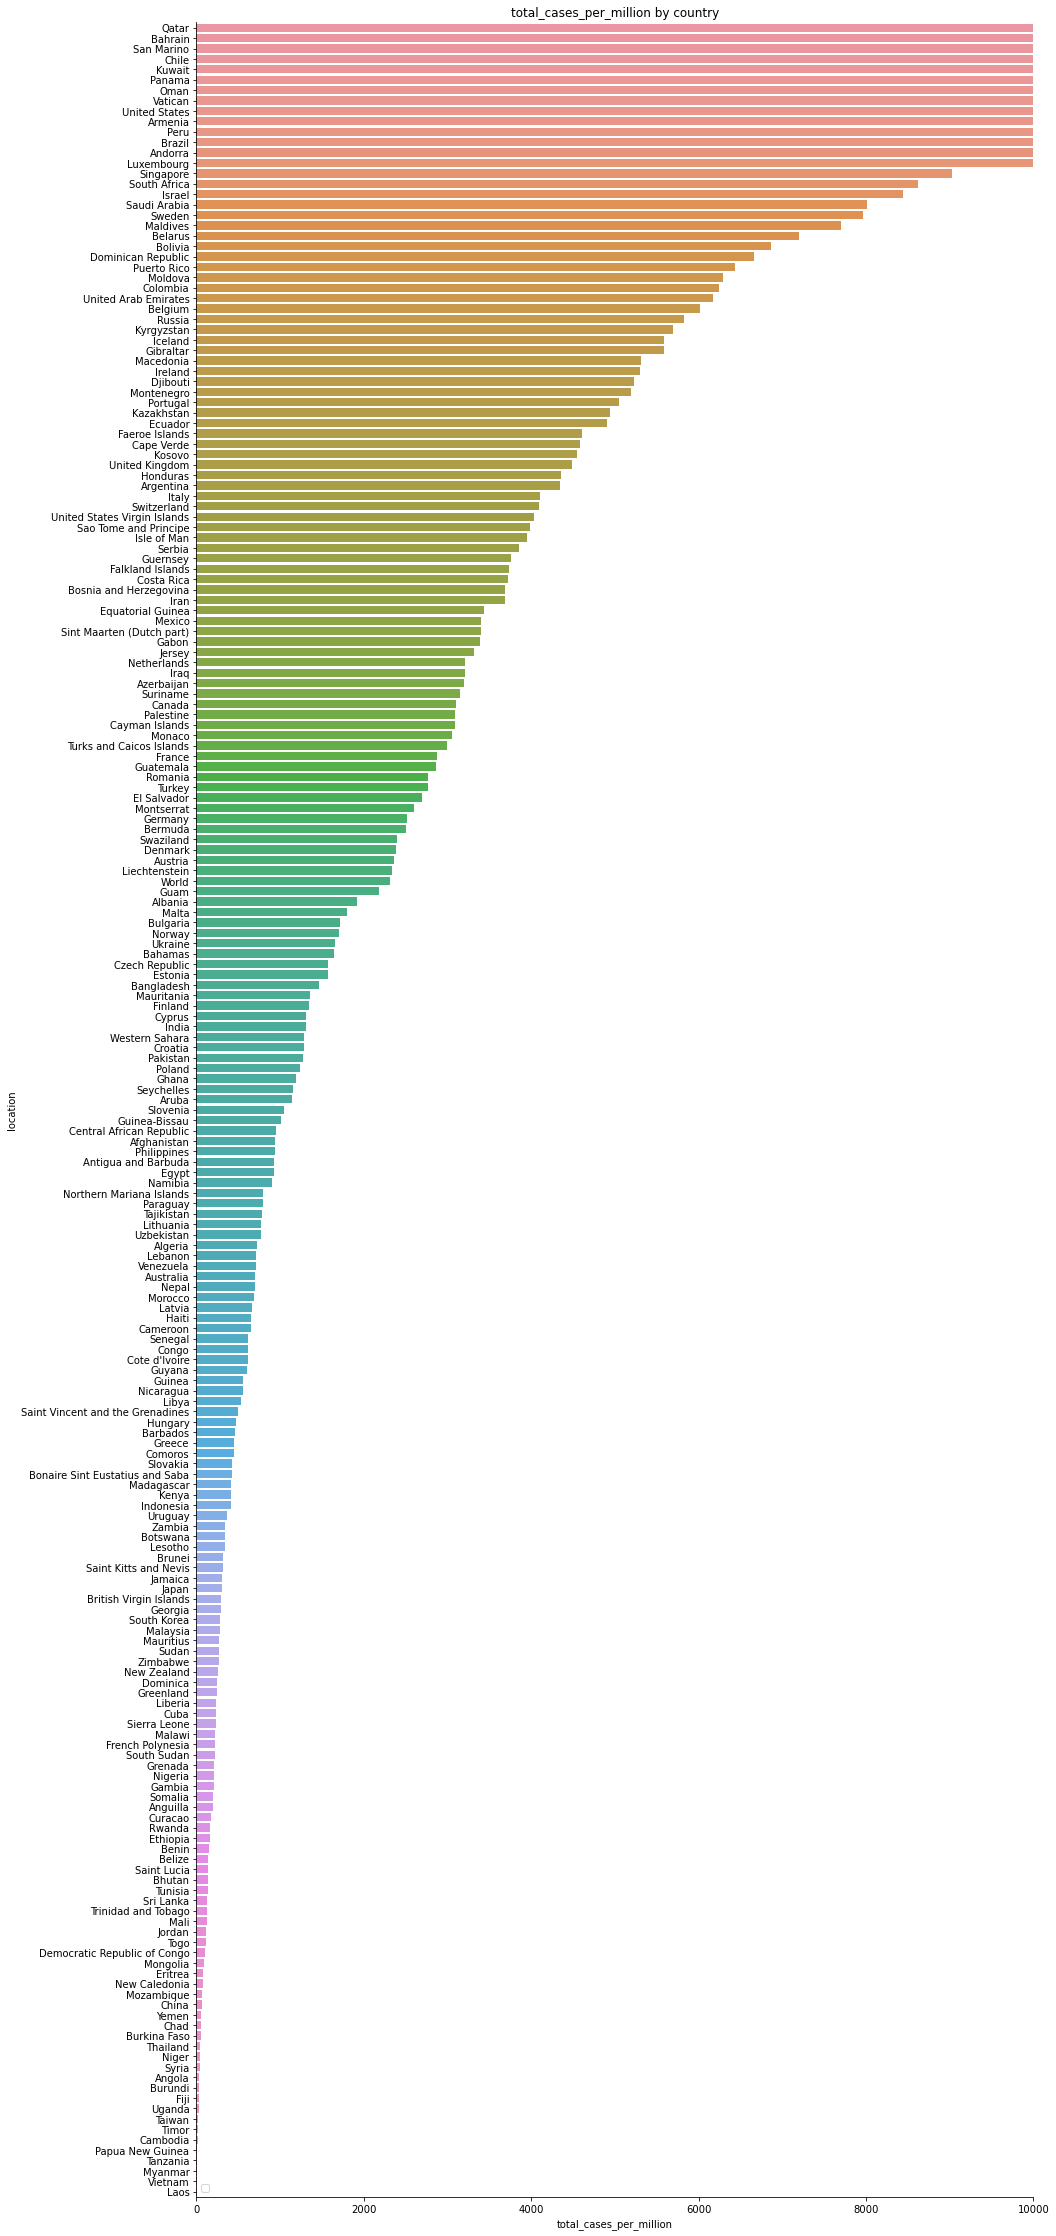

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


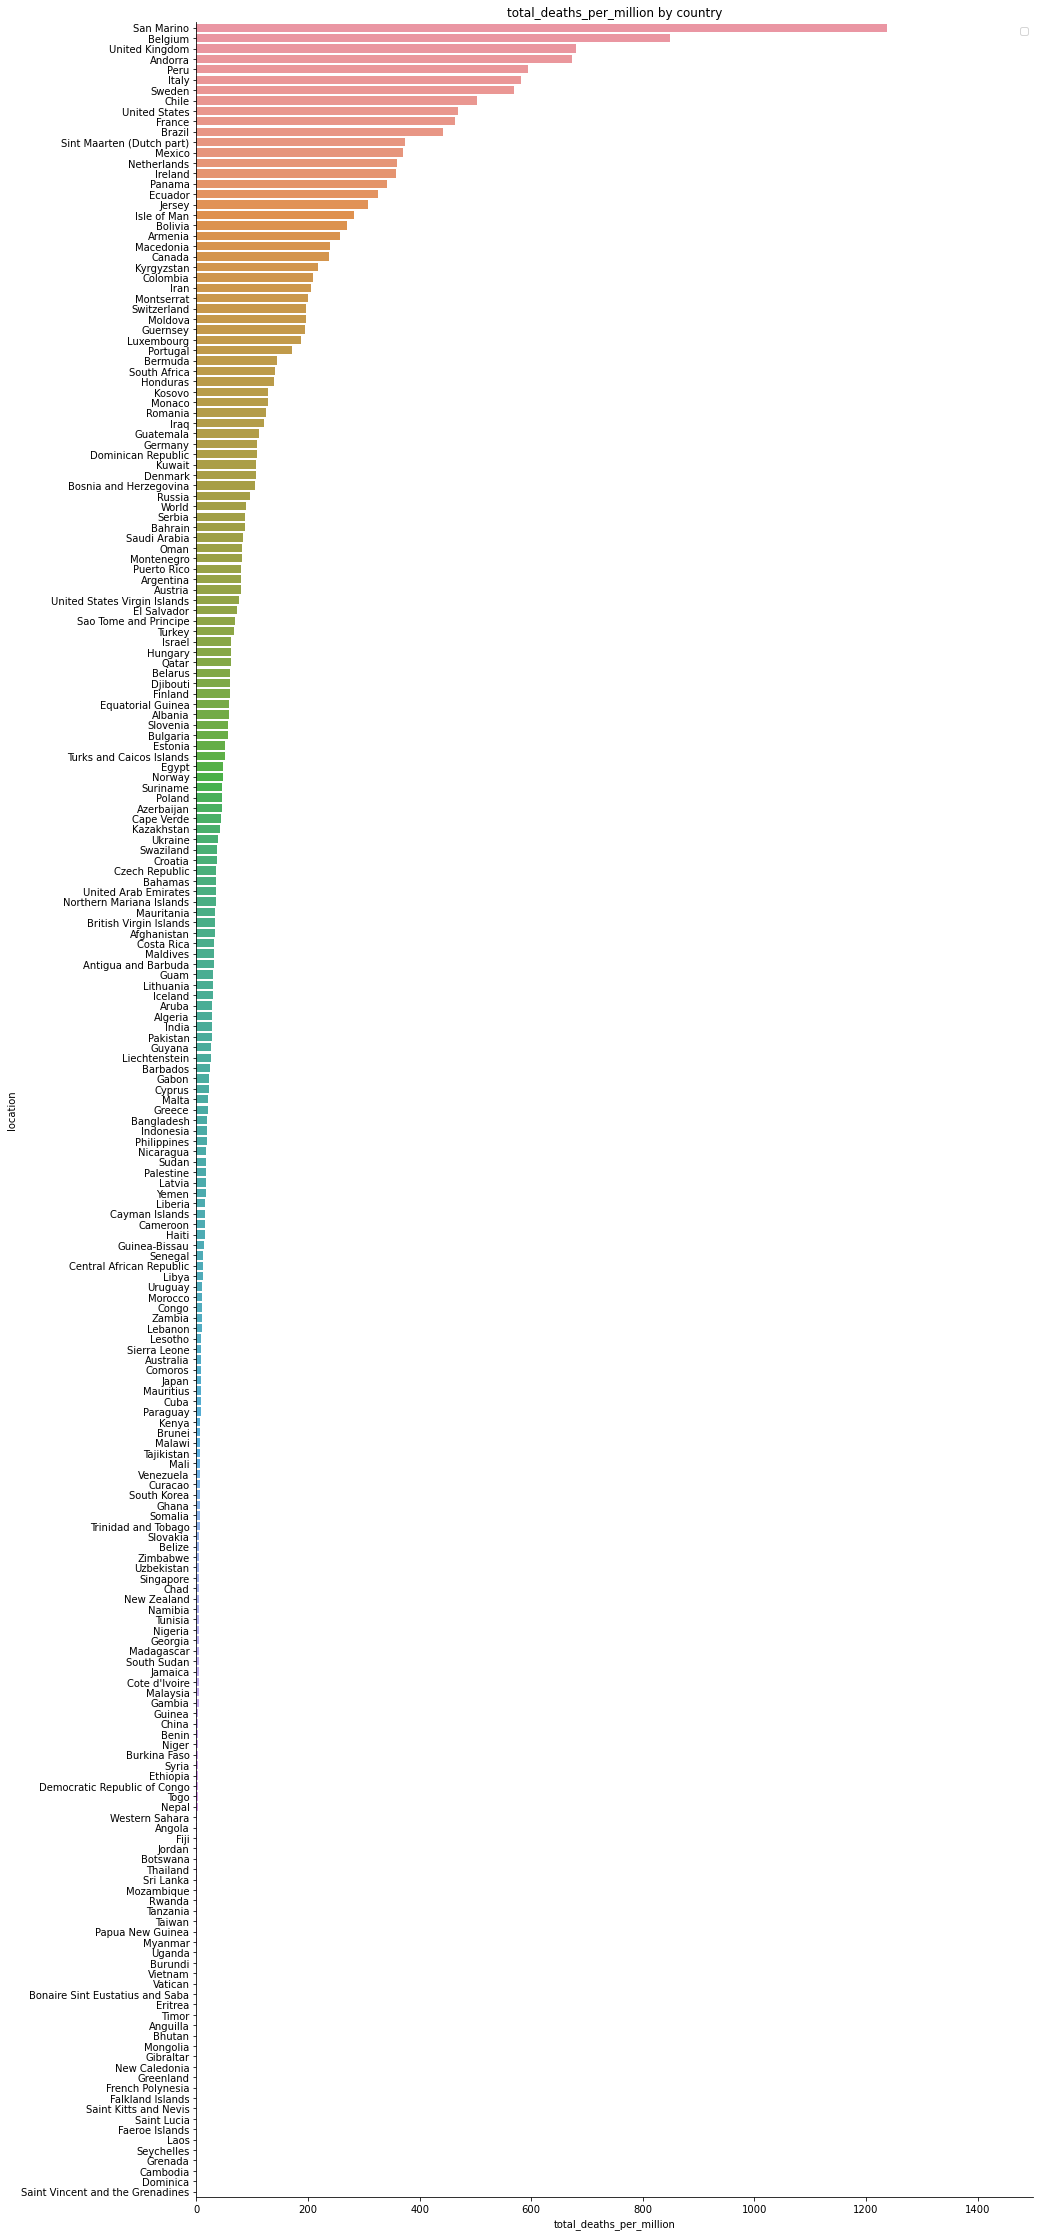

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

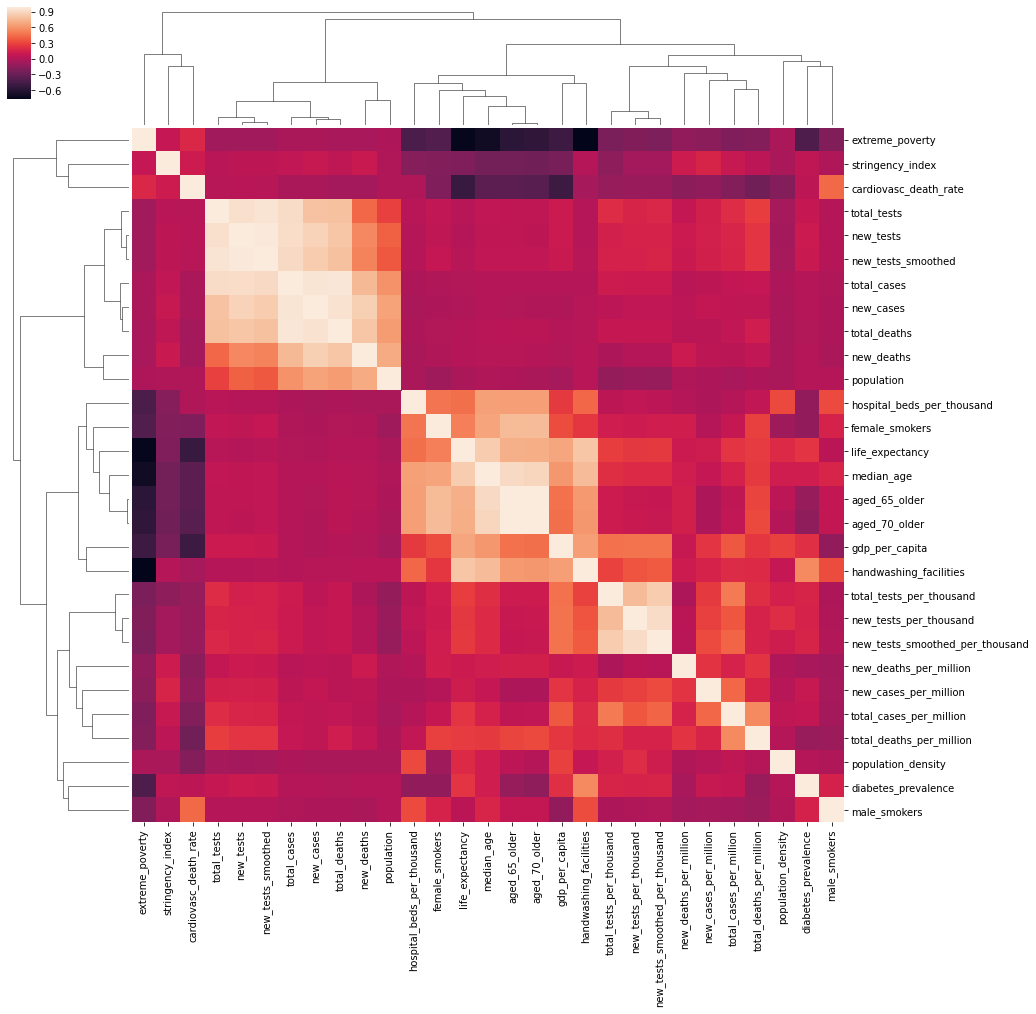

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9996313354650167 (+/- 0.00032048758315009874)
Coef :  [1.04784102e+00 8.23245838e-05 8.74047625e-05]
3 Last_days :  [[17580163 17842067 18056310]]
Today :  18056310
Prediction + :  421427
Tomorow :  18477737
                                     
--------- Total Death -----------------
                                     
R^2: 0.9994912816932424 (+/- 9.318637269588907e-05)
Coef :  [-0.25923635  0.6122306   0.65554871]
3 Last_days :  [[679501 685279 689219]]
Today :  689219
Prediction + :  7661
Tomorow :  696880
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9902552107400919 (+/- 0.003672034787582174)
Coef :  [-0.7082514   0.76206543  0.94606029]
3 Last_days :  [[187919 187919 187919]]
Today :  187919
Prediction + :  290
Tomorow :  188209
                                     
--------- Total Death -----------------
                                     
R^2: 0.4628001310444831 (+/- 0.7116696614138146)
Coef :  [-0.75879659  0.78751194  0.9705198 ]
3 Last_days :  [[30265 30265 30265]]
Today :  30265
Prediction + :  26
Tomorow :  30291
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.48258693211006193 (+/- 0.4456353630532083)
Coef :  [-0.31791056 -0.03201679  1.34418966]
3 Last_days :  [[87655 87827 87985]]
Today :  87985
Prediction + :  134
Tomorow :  88119
                                     
--------- Total Death -----------------
                                     
R^2: -1561.0407451285207 (+/- 2206.746997022116)
Coef :  [-0.0761262   0.01239292  1.05594908]
3 Last_days :  [[4661 4667 4669]]
Today :  4669
Prediction + :  8
Tomorow :  4677
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9285455850429227 (+/- 0.09852340560733294)
Coef :  [-0.84700711  0.90957362  0.9366773 ]
3 Last_days :  [[247537 247832 248070]]
Today :  248070
Prediction + :  398
Tomorow :  248468
                                     
--------- Total Death -----------------
                                     
R^2: 0.9299676263414934 (+/- 0.08654856537356025)
Coef :  [-0.84406785  0.90765048  0.93572213]
3 Last_days :  [[35141 35146 35154]]
Today :  35154
Prediction + :  27
Tomorow :  35181
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6253925680893064 (+/- 0.5154404023034163)
Coef :  [-0.81470718  0.85298204  0.96110739]
3 Last_days :  [[288522 288522 288522]]
Today :  288522
Prediction + :  208
Tomorow :  288730
                                     
--------- Total Death -----------------
                                     
R^2: 0.35024928366741603 (+/- 0.7538602050147951)
Coef :  [-0.70656941  0.5862932   1.11931602]
3 Last_days :  [[28445 28445 28445]]
Today :  28445
Prediction + :  10
Tomorow :  28455
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9925753026639503 (+/- 0.010127194937677985)
Coef :  [0.0122034  0.49966658 0.51047407]
3 Last_days :  [[4562037 4620444 4667955]]
Today :  4667955
Prediction + :  86645
Tomorow :  4754600
                                     
--------- Total Death -----------------
                                     
R^2: 0.5168895504558585 (+/- 0.6539487818989568)
Coef :  [-0.70226523  0.80233431  0.90164517]
3 Last_days :  [[153314 154447 154860]]
Today :  154860
Prediction + :  1219
Tomorow :  156079
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.994605944286699 (+/- 0.006208895519408647)
Coef :  [-0.8015298  0.8863328  0.9153217]
3 Last_days :  [[303181 303952 304695]]
Today :  304695
Prediction + :  985
Tomorow :  305680
                                     
--------- Total Death -----------------
                                     
R^2: 0.5081336413516905 (+/- 0.6892027098528999)
Coef :  [-0.76975892  0.83195851  0.9378258 ]
3 Last_days :  [[46119 46193 46201]]
Today :  46201
Prediction + :  120
Tomorow :  46321
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9962156804865812 (+/- 0.0037076712115869854)
Coef :  [-0.82671565  0.87293481  0.95318883]
3 Last_days :  [[209653 209893 210402]]
Today :  210402
Prediction + :  329
Tomorow :  210731
                                     
--------- Total Death -----------------
                                     
R^2: 0.49570391184905177 (+/- 0.6983610833012937)
Coef :  [-0.80393945  0.84405982  0.95939741]
3 Last_days :  [[9141 9141 9148]]
Today :  9148
Prediction + :  7
Tomorow :  9155
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.812816754302267 (+/- 0.26448786554871395)
Coef :  [0.0368546  0.48857396 0.48785228]
3 Last_days :  [[304204 306752 309437]]
Today :  309437
Prediction + :  3562
Tomorow :  312999
                                     
--------- Total Death -----------------
                                     
R^2: 0.9732800616312027 (+/- 0.03750117364628174)
Coef :  [-0.26794213  0.63895978  0.64107585]
3 Last_days :  [[16766 16982 17190]]
Today :  17190
Prediction + :  214
Tomorow :  17404
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9979972729345287 (+/- 0.002539490432361003)
Coef :  [-0.78446149  0.86947147  0.91210499]
3 Last_days :  [[230873 231869 232856]]
Today :  232856
Prediction + :  928
Tomorow :  233784
                                     
--------- Total Death -----------------
                                     
R^2: 0.999675854761267 (+/- 0.00011001644345803943)
Coef :  [-0.83936529  0.90871924  0.92774747]
3 Last_days :  [[5691 5710 5728]]
Today :  5728
Prediction + :  17
Tomorow :  5745
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.49467546375266974 (+/- 0.7110597990928202)
Coef :  [-0.23033661  0.49208693  0.75879494]
3 Last_days :  [[2662485 2707877 2733677]]
Today :  2733677
Prediction + :  63244
Tomorow :  2796921
                                     
--------- Total Death -----------------
                                     
R^2: 0.5379315582716077 (+/- 0.6489289384761529)
Coef :  [-0.30975567  0.59485853  0.728443  ]
3 Last_days :  [[92475 93563 94104]]
Today :  94104
Prediction + :  1609
Tomorow :  95713
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(18056310, 689219, 18477737, 696880),
 (187919, 30265, 188209, 30291),
 (248070, 35154, 248468, 35181),
 (288522, 28445, 288730, 28455),
 (4667955, 154860, 4754600, 156079),
 (87985, 4669, 88119, 4677),
 (304695, 46201, 305680, 46321),
 (210402, 9148, 210731, 9155),
 (309437, 17190, 312999, 17404),
 (232856, 5728, 233784, 5745),
 (2733677, 94104, 2796921, 95713)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-08-03,France,188209.0,0.0,30291.0,0.0,0.0,0.0
0,2020-08-03,China,88119.0,0.0,4677.0,0.0,0.0,0.0
0,2020-08-03,Italy,248468.0,0.0,35181.0,0.0,0.0,0.0
0,2020-08-03,Spain,288730.0,0.0,28455.0,0.0,0.0,0.0
0,2020-08-03,United States,4754600.0,0.0,156079.0,0.0,0.0,0.0
0,2020-08-03,World,18477737.0,0.0,696880.0,0.0,0.0,0.0
0,2020-08-03,United Kingdom,305680.0,0.0,46321.0,0.0,0.0,0.0
0,2020-08-03,Germany,210731.0,0.0,9155.0,0.0,0.0,0.0
0,2020-08-03,Iran,312999.0,0.0,17404.0,0.0,0.0,0.0
0,2020-08-03,Turkey,233784.0,0.0,5745.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")